In [ ]:
import nltk
import numpy as np
import pandas as pd
import networkx as nx
corpus = pd.read_pickle('/content/drive/MyDrive/deptweet_GNN/corpus_10.p')
corpus.head()

,id,tweet,label,parsed
0,1.622571e+10,Whenever it gets close to my bday I always go ...,non-depressed,"(Whenever, it, gets, close, to, my, bday, I, a..."
1,2.951188e+10,". Yeah, I can see that. My stuff is not depres...",non-depressed,"(., Yeah, ,, I, can, see, that, ., My, stuff, ..."
2,5.290000e+17,My focus has been scattered lately between dif...,mild,"(My, focus, has, been, scattered, lately, betw..."
3,6.540000e+17,"I don't always think it equals depression, tho...",non-depressed,"(I, do, n't, always, think, it, equals, depres..."
4,8.600000e+17,That show was ghastly! It had such an air of w...,non-depressed,"(That, show, was, ghastly, !, It, had, such, a..."


In [ ]:
from collections import Counter
topics = Counter(corpus["label"]).most_common()

#topics=Counter(corpus['label'].value_counts())

In [ ]:
topics

[('non-depressed', 7627), ('mild', 1596), ('moderate', 574), ('severe', 203)]

In [ ]:
corpus.shape

(10000, 4)

In [ ]:
def get_labels(corpus):
    labels= pd.get_dummies(corpus, columns = ['label'])
    label_1=labels.loc[:,'label_mild':'label_severe']
    return label_1

In [ ]:
labels = get_labels(corpus)
labels.head()

,label_mild,label_moderate,label_non-depressed,label_severe
0,0,0,1,0
1,0,0,1,0
2,1,0,0,0
3,0,0,1,0
4,0,0,1,0


In [ ]:
def get_features(corpus):
    return corpus["parsed"]

In [ ]:
def get_features_and_labels(corpus):
    return get_features(corpus), get_labels(corpus)

In [ ]:
def my_spacy_tokenizer(pos_filter=["NOUN", "VERB", "PROPN"]):
    def tokenizer(doc):
        return [token.lemma_ for token in doc if (pos_filter is None) or (token.pos_ in pos_filter)]
    return tokenizer

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
cntVectorizer = TfidfVectorizer(
    analyzer=my_spacy_tokenizer(),
    max_df = 0.25, min_df = 2, max_features = 10000
)

In [ ]:
Features, _ = get_features_and_labels(corpus)

In [ ]:
Transformed = cntVectorizer.fit_transform(Features)

In [ ]:
features = pd.DataFrame.sparse.from_spmatrix(Transformed, index=Features.index)

In [ ]:
features.shape

(10000, 5531)

Creating the Graph

In [ ]:
!git clone https://github.com/stellargraph/stellargraph.git

Cloning into 'stellargraph'...
remote: Enumerating objects: 22627, done.
remote: Counting objects: 100% (96/96), done.
remote: Compressing objects: 100% (75/75), done.
remote: Total 22627 (delta 37), reused 61 (delta 20), pack-reused 22531
Receiving objects: 100% (22627/22627), 95.18 MiB | 21.60 MiB/s, done.
Resolving deltas: 100% (14713/14713), done.


In [ ]:
%cd stellargraph
!pip install .

/content/stellargraph
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/stellargraph
  Preparing metadata (setup.py) ... done
ERROR: Package 'stellargraph' requires a different Python: 3.9.16 not in '<3.9.0,>=3.6.0'


In [ ]:
import stellargraph as sg
from stellargraph import StellarGraph, IndexedArray
from stellargraph.mapper import GraphSAGENodeGenerator
from stellargraph.layer import GraphSAGE
from tensorflow.keras import layers, optimizers, losses, metrics, Model

In [ ]:
edges = pd.read_pickle("/content/drive/MyDrive/deptweet_GNN/BipartiteEdges_10.p")

In [ ]:
entityTypes = {entity: ith for ith, entity in enumerate(edges["type"].unique())}

In [ ]:
entityTypes

{'keywords': 0, 'PERSON': 1, 'GPE': 2, 'ORG': 3}

In [ ]:
tweetFeatures = features.loc[set(corpus.index).intersection(features.index)]

<ipython-input-111-abf7a70828cc>:1: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  tweetFeatures = features.loc[set(corpus.index).intersection(features.index)]


In [ ]:
tweetFeatures.head()

,0,1,2,3,4,5,6,7,8,9,...,5521,5522,5523,5524,5525,5526,5527,5528,5529,5530
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
entities = edges.groupby(["target", "type"])["source"].count().groupby(level=0).apply(
    lambda s: s.droplevel(0).reindex(entityTypes.keys()).fillna(0)
).unstack(level=1)

In [ ]:
entityFeatures = (entities.T / entities.sum(axis=1)).T.assign(document=0, entity=1)

In [ ]:
nodes = {"entity": entityFeatures,
         "document": tweetFeatures}

In [ ]:
stellarGraph = StellarGraph(nodes,
                            edges[edges["source"].isin(tweetFeatures.index)],
                            edge_type_column="type")

In [ ]:
print(stellarGraph.info())

StellarGraph: Undirected multigraph
 Nodes: 29740, Edges: 37642

 Node types:
  entity: [19740]
    Features: float32 vector, length 6
    Edge types: entity-GPE->document, entity-ORG->document, entity-PERSON->document, entity-keywords->document
  document: [10000]
    Features: float32 vector, length 5531
    Edge types: document-GPE->entity, document-ORG->entity, document-PERSON->entity, document-keywords->entity

 Edge types:
    document-keywords->entity: [37480]
        Weights: range=[0.119381, 1], mean=0.364338, std=0.118508
        Features: none
    document-PERSON->entity: [80]
        Weights: range=[2, 5], mean=2.1, std=0.408765
        Features: none
    document-ORG->entity: [59]
        Weights: range=[2, 5], mean=2.20339, std=0.517942
        Features: none
    document-GPE->entity: [23]
        Weights: range=[2, 4], mean=2.13043, std=0.457697
        Features: none


In [ ]:
from stellargraph.data import EdgeSplitter

In [ ]:
splitter = EdgeSplitter(stellarGraph)

In [ ]:
graphTest, samplesTest, labelsTest = splitter.train_test_split(p=0.2)

** Sampled 7528 positive and 7528 negative edges. **


In [ ]:
print(stellarGraph.info())

StellarGraph: Undirected multigraph
 Nodes: 29740, Edges: 37642

 Node types:
  entity: [19740]
    Features: float32 vector, length 6
    Edge types: entity-GPE->document, entity-ORG->document, entity-PERSON->document, entity-keywords->document
  document: [10000]
    Features: float32 vector, length 5531
    Edge types: document-GPE->entity, document-ORG->entity, document-PERSON->entity, document-keywords->entity

 Edge types:
    document-keywords->entity: [37480]
        Weights: range=[0.119381, 1], mean=0.364338, std=0.118508
        Features: none
    document-PERSON->entity: [80]
        Weights: range=[2, 5], mean=2.1, std=0.408765
        Features: none
    document-ORG->entity: [59]
        Weights: range=[2, 5], mean=2.20339, std=0.517942
        Features: none
    document-GPE->entity: [23]
        Weights: range=[2, 4], mean=2.13043, std=0.457697
        Features: none


In [ ]:
print(graphTest.info())

StellarGraph: Undirected multigraph
 Nodes: 29740, Edges: 30114

 Node types:
  entity: [19740]
    Features: float32 vector, length 6
    Edge types: entity-GPE->document, entity-ORG->document, entity-PERSON->document, entity-keywords->document
  document: [10000]
    Features: float32 vector, length 5531
    Edge types: document-GPE->entity, document-ORG->entity, document-PERSON->entity, document-keywords->entity

 Edge types:
    document-keywords->entity: [29982]
        Weights: range=[0.119381, 0.879707], mean=0.364471, std=0.118858
        Features: none
    document-PERSON->entity: [67]
        Weights: range=[2, 5], mean=2.10448, std=0.431148
        Features: none
    document-ORG->entity: [46]
        Weights: range=[2, 5], mean=2.19565, std=0.542405
        Features: none
    document-GPE->entity: [19]
        Weights: range=[2, 4], mean=2.15789, std=0.50146
        Features: none


Classification model


In [ ]:
targets = labels.reindex(tweetFeatures.index).fillna(0)

In [ ]:
targets.head()

,label_mild,label_moderate,label_non-depressed,label_severe
0,0,0,1,0
1,0,0,1,0
2,1,0,0,0
3,0,0,1,0
4,0,0,1,0


In [ ]:
def train_test_split(corpus):
  train_idx = corpus.sample(frac = 0.5)
  test_idx = corpus.drop(train_idx.index)
  return train_idx,test_idx

In [ ]:
sampled, hold_out = train_test_split(targets)

In [ ]:
allNeighbors = np.unique([n for node in sampled.index for n in stellarGraph.neighbors(node)])


In [ ]:
subgraph = stellarGraph.subgraph(set(sampled.index).union(allNeighbors))

In [ ]:
print(subgraph.info())

StellarGraph: Undirected multigraph
 Nodes: 16144, Edges: 18846

 Node types:
  entity: [11144]
    Features: float32 vector, length 6
    Edge types: entity-GPE->document, entity-ORG->document, entity-PERSON->document, entity-keywords->document
  document: [5000]
    Features: float32 vector, length 5531
    Edge types: document-GPE->entity, document-ORG->entity, document-PERSON->entity, document-keywords->entity

 Edge types:
    document-keywords->entity: [18757]
        Weights: range=[0.125305, 1], mean=0.364996, std=0.118476
        Features: none
    document-PERSON->entity: [40]
        Weights: range=[2, 5], mean=2.175, std=0.549475
        Features: none
    document-ORG->entity: [36]
        Weights: range=[2, 5], mean=2.22222, std=0.590937
        Features: none
    document-GPE->entity: [13]
        Weights: all 2
        Features: none


In [ ]:
from sklearn.model_selection import train_test_split

train, leftOut = train_test_split(
    sampled,
    train_size=0.1,
    test_size=None,
    random_state=42,
)

validation, test = train_test_split(
    leftOut, train_size=0.2, test_size=None, random_state=100,
)

In [ ]:
validation = validation[validation.sum(axis=1) > 0]
test = test[test.sum(axis=1) > 0]

In [ ]:
print(f"Validation: {validation.shape}")
print(f"Test: {test.shape}")

Validation: (900, 4)
Test: (3600, 4)


Training the model


In [ ]:
batch_size = 50
num_samples = [10, 5]

In [ ]:
from stellargraph.mapper import HinSAGENodeGenerator

generator = HinSAGENodeGenerator(subgraph, batch_size, num_samples, head_node_type="document")

In [ ]:
from stellargraph.layer import HinSAGE

graphsage_model = HinSAGE(
    layer_sizes=[32, 32], generator=generator, bias=True, dropout=0.5,
)

In [ ]:
x_inp, x_out = graphsage_model.in_out_tensors()
prediction = layers.Dense(units=train.shape[1], activation="sigmoid")(x_out)

/usr/local/lib/python3.9/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [ ]:
prediction.shape

TensorShape([None, 4])

In [ ]:
model = Model(inputs=x_inp, outputs=prediction)
model.compile(
    optimizer=optimizers.Adam(lr=0.005),
    loss=losses.binary_crossentropy,
    metrics=["acc"],
)

In [ ]:
train_gen = generator.flow(train.index, train, shuffle=True)

In [ ]:
val_gen = generator.flow(validation.index, validation)


In [ ]:
history = model.fit(
    train_gen, epochs=50, validation_data=val_gen, verbose=1, shuffle=False
)

Epoch 1/50
10/10 [==============================] - 104s 9s/step - loss: 0.6557 - acc: 0.5140 - val_loss: 0.5925 - val_acc: 0.7822
Epoch 2/50
10/10 [==============================] - 84s 9s/step - loss: 0.5759 - acc: 0.7480 - val_loss: 0.5283 - val_acc: 0.7833
Epoch 3/50
10/10 [==============================] - 73s 7s/step - loss: 0.5308 - acc: 0.7580 - val_loss: 0.4931 - val_acc: 0.7833
Epoch 4/50
10/10 [==============================] - 83s 9s/step - loss: 0.5032 - acc: 0.7600 - val_loss: 0.4726 - val_acc: 0.7833
Epoch 5/50
10/10 [==============================] - 85s 9s/step - loss: 0.4862 - acc: 0.7600 - val_loss: 0.4580 - val_acc: 0.7833
Epoch 6/50
10/10 [==============================] - 76s 8s/step - loss: 0.4709 - acc: 0.7600 - val_loss: 0.4459 - val_acc: 0.7833
Epoch 7/50
10/10 [==============================] - 82s 9s/step - loss: 0.4587 - acc: 0.7600 - val_loss: 0.4355 - val_acc: 0.7833
Epoch 8/50
10/10 [==============================] - 82s 9s/step - loss: 0.4464 - acc: 0.7

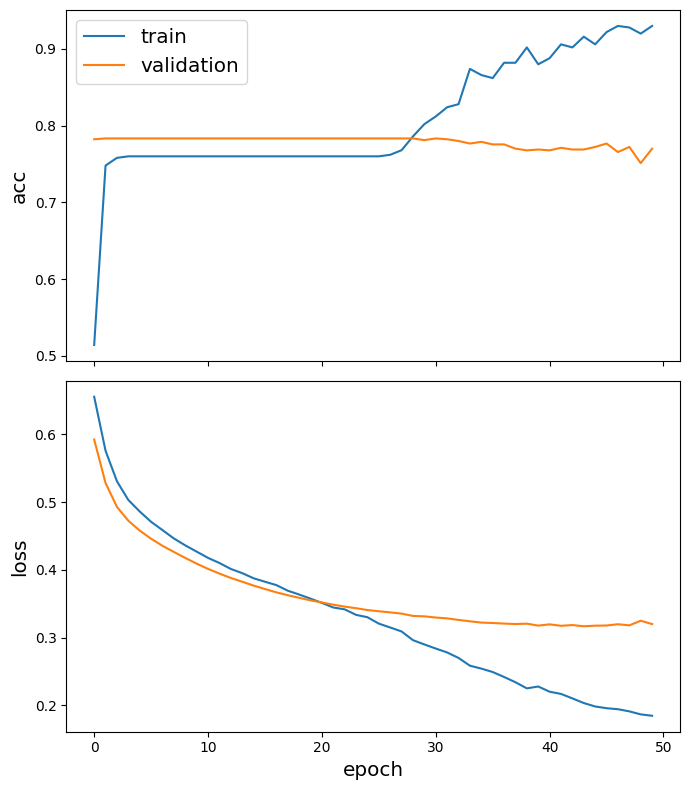

In [ ]:
sg.utils.plot_history(history)

In [ ]:
history = model.fit(
    train_gen, epochs=50, validation_data=val_gen, verbose=1, shuffle=False
)

Epoch 1/50
10/10 [==============================] - 87s 9s/step - loss: 0.1827 - acc: 0.9240 - val_loss: 0.3256 - val_acc: 0.7500
Epoch 2/50
10/10 [==============================] - 73s 8s/step - loss: 0.1766 - acc: 0.9340 - val_loss: 0.3179 - val_acc: 0.7667
Epoch 3/50
10/10 [==============================] - 83s 9s/step - loss: 0.1724 - acc: 0.9420 - val_loss: 0.3196 - val_acc: 0.7611
Epoch 4/50
10/10 [==============================] - 82s 9s/step - loss: 0.1751 - acc: 0.9260 - val_loss: 0.3192 - val_acc: 0.7622
Epoch 5/50
10/10 [==============================] - 84s 9s/step - loss: 0.1669 - acc: 0.9380 - val_loss: 0.3279 - val_acc: 0.7411
Epoch 6/50
10/10 [==============================] - 85s 9s/step - loss: 0.1656 - acc: 0.9420 - val_loss: 0.3198 - val_acc: 0.7633
Epoch 7/50
10/10 [==============================] - 83s 9s/step - loss: 0.1636 - acc: 0.9420 - val_loss: 0.3235 - val_acc: 0.7633
Epoch 8/50
10/10 [==============================] - 83s 9s/step - loss: 0.1631 - acc: 0.94

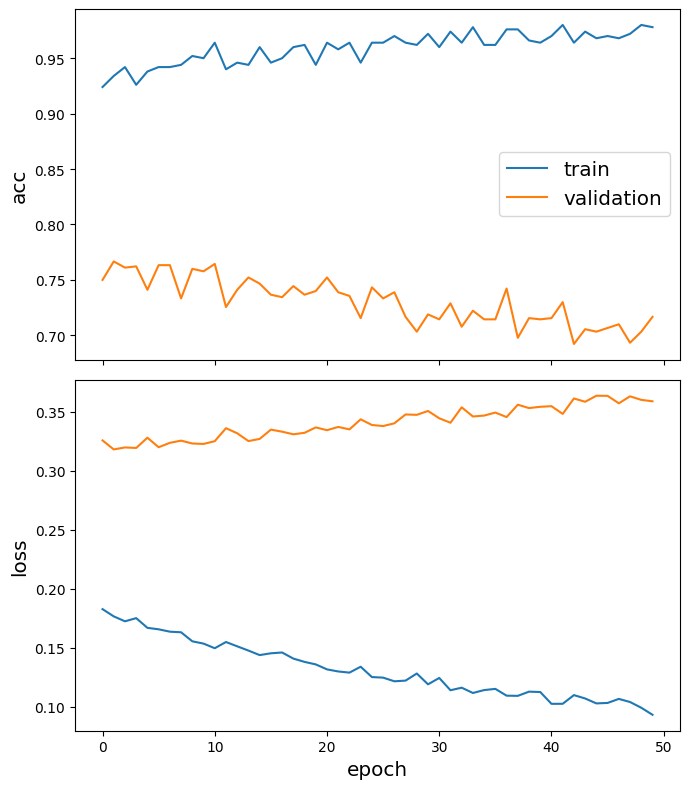

In [ ]:
sg.utils.plot_history(history)


In [ ]:
test_gen = generator.flow(test.index, test)

In [ ]:
test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

72/72 [==============================] - 133s 2s/step - loss: 0.3937 - acc: 0.6853

Test Set Metrics:
	loss: 0.3937
	acc: 0.6853


In [ ]:
test_predictions = pd.DataFrame(model.predict(test_gen), index=test.index, columns=test.columns)

72/72 [==============================] - 126s 2s/step


In [ ]:
test_results = pd.concat({
    "target": test,
    "preds": test_predictions
}, axis=1)

In [ ]:
from sklearn.metrics import f1_score, classification_report


<Axes: >

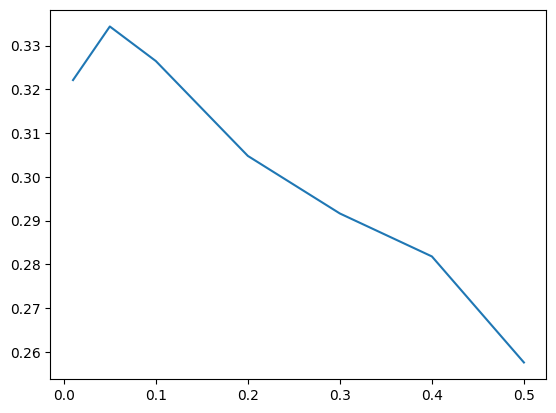

In [ ]:
f1s = {}

for th in [0.01,0.05,0.1,0.2,0.3,0.4,0.5]:
    f1s[th] = f1_score(test_results["target"], 1.0*(test_results["preds"]>th), average="macro")

pd.Series(f1s).plot()

In [ ]:
print(classification_report(test_results["target"], 1.0*(test_results["preds"]>0.08)))

              precision    recall  f1-score   support

           0       0.20      0.60      0.30       589
           1       0.08      0.21      0.11       200
           2       0.76      1.00      0.86      2743
           3       0.04      0.15      0.06        68

   micro avg       0.51      0.87      0.64      3600
   macro avg       0.27      0.49      0.33      3600
weighted avg       0.62      0.87      0.72      3600
 samples avg       0.60      0.87      0.68      3600



In [ ]:
generator = HinSAGENodeGenerator(stellarGraph, batch_size, num_samples, head_node_type="document")

In [ ]:
hold_out = hold_out[hold_out.sum(axis=1) > 0]


In [ ]:
hold_out_gen = generator.flow(hold_out.index, hold_out)


In [ ]:
hold_out_predictions = (model.predict(hold_out_gen))

100/100 [==============================] - 174s 2s/step


In [ ]:
preds = pd.DataFrame(1.0*(hold_out_predictions > 0.08), index=hold_out.index, columns=hold_out.columns)

In [ ]:
results = pd.concat({
    "target": hold_out,
    "preds": preds
}, axis=1)

In [ ]:
print(classification_report(results["target"], results["preds"]))

              precision    recall  f1-score   support

           0       0.21      0.65      0.32       802
           1       0.08      0.18      0.11       291
           2       0.76      1.00      0.86      3799
           3       0.06      0.17      0.09       108

   micro avg       0.52      0.88      0.66      5000
   macro avg       0.28      0.50      0.35      5000
weighted avg       0.62      0.88      0.72      5000
 samples avg       0.61      0.88      0.69      5000

